In [ ]:
#@title Copyright 2021 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Detecting Changes in Sentinel-1 Imagery (Part 4)

Author: mortcanty

In the fourth and final part of this Community Tutorial series on SAR change detection, we will have a look at some more examples using imagery taken from the [GEE Sentinel-1 Archive](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD). In order to encourage further exploration, the algorithm that we developed in the first three parts ([Part 1](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1), [Part 2](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2), [Part 3](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-3))
has been provided with a convenient interactive widget interface. Some of the examples presented here are taken from the publications
[Canty et al. (2020)](https://www.mdpi.com/2072-4292/12/1/46) and [Canty et al. (2020a)](https://www.mdpi.com/2072-4292/12/15/2454).




### Calculate year frequency

In [ ]:
!pip install rasterio

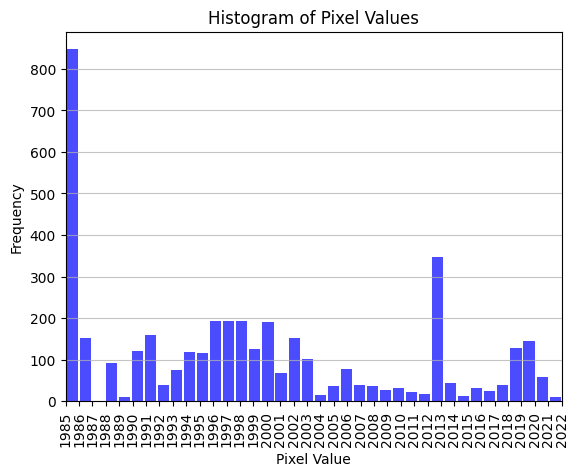

In [19]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 读取tif文件
with rasterio.open(r'F:\esriContest\composited\041032\out\slc-change-map-1972-2024.tif') as src:
    band = src.read(1)

# 忽略NaN值
valid_values = band[np.isfinite(band)]

# 获取唯一值
unique_values = np.unique(valid_values)

# 绘制直方图
plt.hist(valid_values, bins=len(unique_values), color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Values')

# 设置横轴刻度为所有唯一值, 调整刻度标签方向
plt.xticks(unique_values, rotation='vertical')

# 根据需要调整横轴的显示范围
plt.xlim(min(unique_values), max(unique_values))

plt.show()

choose year bigger then 2014

### Preliminaries

In [ ]:
# Setup the GEE Python API.
import ee
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()

In [ ]:
# Enable the Widget manager.
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# Install the algorithm and the interactive interface (from fresh runtime!).
!pip install -q ipyleaflet
!git clone https://github.com/mortcanty/eesarseq
%cd /content/eesarseq/src
%run setup install

# Part 4. Applications: exploring the GEE Sentinel-1 collection



In [ ]:
# Run the interface.
from eesar.application import run
run()

## How to use the interface

### Caveat

*The sequential SAR change detection method that we developed in the first three parts of this tutorial is _pixel-oriented_. That is to say, it is based entirely on the statistical properties of each and every multi-look pixel in the observed image series. For this reason it is best to limit your analysis to a region less than a few thousand square kilometers while interactively visualizing and exploring results using this notebook (for larger regions, [export the results](https://developers.google.com/earth-engine/guides/python_install#exporting-data)). Furthermore, since we are analysing time series for changes, the reflectance images involved must all completely overlap the region of interest and have been irradiated from the same position in space. This means choosing either ascending **or** descending node, and only **one** relative orbit number for any given sequence.*

### Walk through

To get started, let's see how to generate a small change map. In the widget interface above, choose **Platform** A, leaving all other settings as is. Select a small area of interest (aoi) near the town of Jülich with the rectangular or polygon **draw tool**. This will enable the **Collect** button. Click it to collect an image series, the details of which are printed in the info box at the bottom. The raster overlay shows the complete swath of the last image in the sequence. When the overlay is fully rendered, the **Preview** button is enabled.

**Note:** Depending on the position of the aoi, two relative orbit numbers may be displayed (88 and 15). If so, in the corresponding **RelOrbit** field choose either of them and re-collect.

The **Preview** button will  now trigger the change detection algorithm at the scale selected by the current zoom setting. The color coded change map is displayed, showing, for each pixel, the interval within the series of the **First** detected change (palette = 'black, blue, cyan, yellow, red' indicating early in the series through to late). The map displayed is set by the Radio Button next to **Preview**.  Since processing is carried out in parallel, the change image is built up tile-by-tile. As explained in [Part 3](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-3#a_question_of_scale)  of this tutorial, the zoom setting can falsify the result somewhat, depending on the pyramid level at which the calculation is carried out. Nevertheless it is often convenient for generating a quick overview. You can see the effect by zooming in and out. De-select the **QuickPreview** check box to override it. Now the calculation is carried out at the full 10 m pixel scale irrespective of the zoom level chosen, but can take considerably longer.

If and when you are satisfied with the previewed result, you can export the change maps to your GEE cloud assets with the **ExportToAssets** button, see below.

### The widgets

**Platform:** Choose one or both of the Sentinel-1 satellites.

**Pass:** Choose ascending or descending node.

**RelOrbit:** Choose relative orbit number. If set to 0 all orbit numbers are included with images which overlap with the area of interest.

**StartDate:** Beginning of collected time series.

**EndDate:** End of collected time series.

**Collect:** Start collection, enabled when an area of interest has been chosen. Upon completion the last Sentinel-1 image in the sequence is displayed.

**Signif:** Choose a significance level for the [likelihood ratio test](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#the_likelihood_ratio_test).

**MedianFilter:** Run a 5x5 median filter over the change map before displaying or exporting.

**Stride:** Select only a subset of the collected sequence. For example, the value 3 will collect every third image in the sequence.

**ShowS2:** Display the most cloud-free Sentinel-2 image found within the chosen time period instead of the last Sentinel-1 image.

**ExportToAssets:** Creates and runs a batch task to export a change map image as a raster to an Earth Engine asset.  For a time series of $k$ images, the exported change map consists of $k+2$ bands
- cmap: the interval* of the most recent change, one band, byte values $\in [0,k-1]$, where 0 = no change.
- smap: the interval of the first change, one band, byte values $\in [0,k-1]$, where 0 = no change.
- fmap: the number of changes, one band, byte values $\in [0,k-1]$, where 0 = no changes.
- bmap: the changes in each interval, $\ k-1$ bands, byte values $\in [0,3]$, where 0 = no change, 1 = positive definite change, 2 = negative definite change, 3 = indefinite change.

*Two successive acquisition times in the series.

**ExportToDrive:** Sends the change map described above to Drive storage in GeoTIFF format.

**Preview:** Run the change detection algorithm and preview results according to the chosen settings (often slow, depending upon series length, zoom level and size of the aoi).

**ReviewAsset:** Display a currently selected change map asset according to the chosen settings (very fast, since calculations have already been performed).

**PlotAsset:** Plot the proportion of change pixels in the bmap bands of the selected asset as a function of time.

**Bitemporal:** Preview (or ReviewAsset) the change map for one interval of the series (black = no change, red = positive definite, cyan = negative definite, yellow = indefinite).

**Interval:** Choose the interval for the Bitemporal map.

**First:** Preview (or ReviewAsset) the smap band (palette = 'black, blue, cyan, yellow, red' indicating no change, early in the series through to late).

**Last:** Preview (or ReviewAsset) the cmap band (palette = 'black, blue, cyan, yellow, red' indicating no change, early in the series through to late).

**Frequency:** Preview (or ReviewAsset) the fmap band (palette = 'black, blue, cyan, yellow, red' indicating no change, few changes through to many).

**MaxFreq:** The number of changes in the frequency map which corresponds to  'red' or 'many'.

**NCMask:** Mask out (make transparent) the no change pixels in the Preview (or ReviewAsset) overlays.

**WaterMask:** Mask out (make transparent) the water pixels in the Preview (or ReviewAsset) overlays.

**QuickPreview:** When set, calculate the Preview at the pyramid level corresponding to the current zoom level. Otherwise use the native scale of 10 m.

**Opacity:** Set the opacity in the Preview (or ReviewAsset) overlays.

**Clear:** Clear the output window.

**GoTo:** Jump to a geographic location.

## Some examples

### Surveillance

Remote sensing surveillance, or monitoring, applications are most often associated with very high resolution satellite or aerial sensors. The Sentinel-1 C-band ground range detected imagery on GEE is obviously much less applicable to such tasks. This is mainly due to the relatively poor spatial resolution ($\approx 20m$) and the ever-present speckle in the archived images.

On the other hand, a guaranteed, all-weather revisit time of 6 days might be usefully exploited in some circumstances. Seaport activity monitoring is one possibility, with the frequency of large vessel arrival and departure (usually quoted as ATT or average turnaround time) being in general [of the order of days](https://globalmaritimehub.com/wp-content/uploads/2019/10/CIRRELT-2019-20.pdf). Thus a change signal generated every 6 days from our sequential algorithm might be expected to catch a large proportion of cargo or large passenger ship movements at a given seaport.

As a specific example, ports along the coast of Libya have been the subject of recent international attention, in part due to the refugee crisis in the Mediterranean and also because of Libyan political instability. Some of them have been closed periodically to international traffic. The port of Benghazi was closed in the first part of 2017, [reopening on 5 October](https://www.reuters.com/article/libya-security-benghazi-port-idINKCN1C61MC). This is verified in the change frequency plots below which were generated directly from the interface. The change observations are partly confused by noise from open water, caused mostly by surface wave conditions, but the signals of interest are quite clear. (The water mask would remove the noise, but also hide some ship movements.)

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/bengasi2017.png?raw=1" width="500px"><img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/bengasi2018.png?raw=1" width="500px">

_Fig. 1. Left: Port of Benghazi change frequency 2017-01-01 to 2017-10-04 (44 images, platforms A and B, relative orbit 73, ascending node). Right: For 2018-01-01 to 2018-10-04._

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/bengasi2017-8.png?raw=1">

_Fig. 2. Proportion of changed pixels in a small aoi around the main dock in Benghazi for a 60-image time sequence. There were about 900  pixels in all in the aoi. Note the (approximate) alternation of arrivals (positive definite changes) and departures (negative definite changes)._

The covid pandemic had a very significant effect on Mediterranean tourist seaports and, unless you happen to be maybe a Venetian merchant or hotel operator, certainly a positive one. Try using the same techniques as above on the main passenger ship dock in Venice, choosing a time series covering pre-covid to the present.

Another, more future-oriented application of SAR change detection, might be the verification of the [decommissioning of large open face coal mines](https://www.mining-technology.com/sponsored/decommissioning-mining-energy-assets/) in national programs for $CO_2 $ reduction. The Hambach open pit coal mine west of Cologne, Germany is depicted in the single interval, Loewner order change image below. The large digging and back-filling machines are visible in the change series only by virtue of their movement (cyan: machine present $\to$ machine absent, and red: vice versa) and would disappear if all mining activity were to stop.

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/hambach2020.png?raw=1">

_Fig. 3. Single interval (bitemporal) changes (May 13 to May 19) over the Hambach open pit mine from a series of 55 images covering the year 2020._


### Inundation

In [Part 3](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-3) of this series we used a catastrophic flooding event in England to introduce and illustrate the sequential change detection algorithm. This is in fact a widely known application of SAR.  Quoting from the [Office for Outer Space Affairs UN-SPIDER Knowledge Portal](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-flood-mapping/python-step-by-step):

> _The usage of Synthetic Aperture Radar (SAR) satellite imagery for flood extent mapping constitutes a viable solution with fast image processing, providing **near real-time flood information** (my emphasis) to relief agencies for supporting humanitarian action. The high data reliability as well as the absence of geographical constraints,  such as site accessibility, emphasize the technology’s potential in the field._

And here, as another illustration, is an excerpt from [Canty et al. (2020)](https://www.mdpi.com/2072-4292/12/1/46):

> _Cyclone Idai, recorded as the worst weather-based event to ever occur in the southern hemisphere, made landfall near the city of Beira, Mozambique on March 15, 2019 causing widespread inundation in Mozambique and Tanzania and a death toll of more than 1300. Figure 4 shows a sequence of six change maps generated with a GEE time series of Sentinel-1a and Sentinel-1b images. The reduction of reflectance from the water surfaces in both the VV and VH bands corresponds to a negative definite covariance matrix difference (green pixels, center left), the rapid receding of flood waters to a positive definite change (red pixels, center right)._

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/buzi2019.png?raw=1">

_Fig. 4 Buzi district, Mozambique: Six change maps of 15 in all for 16 images covering the period Jan 1, 2019, through June 7, 2019. Each image has an area of approximately 3000 km$^2$. The gray scale background is the temporal average of the VV band of all 16 images. The maps, read top to bottom, left to right, are for the intervals April 18-March 2, March 2-14, March 14-20, March 20- 26, March 26-April 1 and April 1-7. Positive definite changes are red, negative definite green and indefinite yellow._

You can easily reproduce the above sequence with the interactive interface, remembering that negative definite changes are now shown as cyan.
The change signal from within the partially inundated city of Beira, just to the east of the scene, is considerably less convincing, as you can also verify yourself. This is due to the predominance of so-called double bounce scattering from built up areas, an effect which is present in both dry and flooded areas.

### Vegetation

When contrasted with visual/infrared remote sensing data, individual SAR images are of relatively limited use for detecting or classifying different vegetation types. Time series of radar images (preferably speckle filtered) have some potential for supervised classification, see for example [Canty, 2021](https://gist.github.com/mortcanty/bbdaab2835334e949a45d7c3b7bf0396). If full polarimetric images are acquired by the satellite antenna (as is the case for example for the RadarSat-2 platform) then the $3\times 3$ _quad-pol covariance matrix_ can be transformed in various ways to generate polarimetry indices for qualitative and quantitative physical information [(Moreira et al. 2013)](https://elib.dlr.de/82313/).

[Equation (1.5) in Part 1](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1#single_look_complex_slc_sar_measurements) is the analogous $2\times 2$ _dual-pol covariance matrix_ generated from the Sentinel-1 platform, and it is considerably less amenable to polarimetric methods. Also, as we know, only its diagonal elements are available in the GEE archive. But if polarimetry is not an option, we can still take advantage of the temporal information supplied by sequential change detection. As a simple example, crop dynamics in an agricultural area can be traced over a growing period to discriminate early and late harvesting, see Figure 5.

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/juelicherland.png?raw=1" width="500px">
<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/juelicherlands2.png?raw=1" width="500px">

_Fig. 5 Left: A change map (the cmap band) showing the most recent significant changes for the time interval January to November, 2018, generated from a series of 51 images over an agricultural region near Jülich, Germany. Right: RGB composite of a Sentinel-2 image acquired over the same area on July 2, 2018._

Roughly four classes can be distinguished in the left hand image:

- black (no change): forests, motorways, built-up areas (villages)
- light blue (early harvesting): winter wheat ...
- orange/green (late summer harvesting): rapeseed ...
- red (autumn harvesting): sugar beet, corn ...

This is  partly guessing, but the dynamics could well be included as an additional feature in a supervised classification scheme, for instance to complement the spectral bands of a cloud-free Sentinel-2 image such as shown in the right-hand figure.

An extremely topical theme associated with "vegetation changes" is of course deforestation, either intentional (e.g., conversion to non-forested land for agricultural use) or accidental (e.g., bush fires). A drastic example of the latter was the fire that destroyed almost all of the forest of Kangaroo Island, Australia, in 2019/2020.

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/kangarooislandmap.png?raw=1" width="1000px">

_Fig. 6 Kangaroo Island._

Quoting from the [tourkangarooisland](https://www.tourkangarooisland.com.au/kangaroo-island-fires) website:

> _Fires started on the North Coast of the Island on the 20th December, 2019, from lightning strikes, and by the 30th December were relatively under control, burning within contained lines.  On the night of the 30th December, more lightning strikes hit the island, this time within the Ravine des Casoars Wilderness Protection Area, north of the Flinders Chase National Park.  As conditions deteriorated, emergency service personnel worked closely with the community around the western end of the island, and by the 2nd January, 2020 evacuations begun. On the 3rd January, 2020 the western end of the island, home to the Flinders Chase National Park, and the adjoining Ravine des Casoars Wilderness Protection area was burnt along with Kelly Hill Conservation Park.  Fires continued to burn across the island for some weeks, two lives were lost, many businesses, homes and farms were lost, countless numbers of livestock, and precious habitat and wildlife perished._

The images shown below, all of which were generated with the widget interface, confirm the above scenario, and also indicate how well the Sentinel-1 time series analysis complements visual/infrared remote sensing data.

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/kangarooislandwests2oct.png?raw=1" width="500px">
<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/kangarooislandwests2feb.png?raw=1" width="500px">

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/kangarooislandwest.png?raw=1" width="500px">
<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/kangarooislandplt.png?raw=1" width="500px">

_Fig. 7 Top left: Sentinel-2 image from October 22, 2019 over the western end of Kangaroo Island. Top right: Sentinel-2 image from February 9, 2020. Bottom left: Change map showing first significant changes (smap) for a sequence of 15 Sentinel-1 images from October, 2019 through March, 2020. The "blue changes" precede those due to the bush fire (green/yellow) and correspond to vegetation changes in unforested areas. Bottom right: Proportion of changed pixels in the full scene, Figure 8. The first peak precedes the fire._


<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/kangarooisland12_18.png?raw=1" width="500px">
<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/kangarooisland18_19.png?raw=1" width="500px">

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/kangarooisland19_20.png?raw=1" width="500px">
<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/kangarooisland20_21.png?raw=1" width="500px">

_Fig. 8 Map of the first significant changes for the entire scene (110 km from east to west), for the periods July, 2017 to July, 2018 (top left), July, 2018 to July, 2019 (top right), July, 2019 to July, 2020 (bottom left), July, 2020 to July, 2021 (bottom right). Some regeneration is apparent in the last scene._



Clear cut logging is not considered to be deforestation, rather harvesting with recultivation. It is nevertheless extremely controversial, at least in North America. Clear cuts, by their nature, stand out "clearly" in optical imagery, as can be seen from the example on the left in Figure 9. Unless a cloud-free visual/infrared time series is available, the time at which logging took place may be difficult to determine. The SAR change image (right side of Figure 9) places it in this case at November/December, 2017, see also Figure 10. Care has to be taken to determine the _first_ changes at the location, since snowfall/snowmelt or spring/summer vegetation can generate change signals in existing clear cuts. This is apparent in Figure 10.

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/ontario17_18_bg.png?raw=1" width="500px">
<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/ontario17_18.png?raw=1" width="500px">

_Fig. 9 A clear cut north of Lake Superior in Ontario, Canada. Left: Ersri.WorldImagery background image acquired after the clear cut. Right: The first significant changes (smap) for a time series of 19 images from June, 2017 to March 2018. The cut measures approximately 2.5 km north to south._

<img src="https://github.com/mortcanty/eesarseq/blob/main/screenshots/ontario17_19plot.png?raw=1" width="500px">

_Fig. 10 Proportion of changed pixels for a 51 image time series over a small aoi centered on the clear cut for the years 2017 and 2018. Logging took place in November and December, 2017. The large positive definite change in April, 2018 is most probably snow melt._

### The end

This concludes the community tutorial series on SAR change detection.  For readers that would like to delve more deeply into the theory, here are the relevant publications:

- [Knut Conradsen, Allan Aasbjerg Nielsen, Jesper Schou and Henning Skriver (2003). A test statistic in the complex Wishart distribution and its application to change detection in polarimetric SAR data.](https://doi.org/10.1109/TGRS.2002.808066)

- [Knut Conradsen, Allan Aasbjerg Nielsen and Henning Skriver (2016). Determining the points of change in time series of polarimetric SAR data.](https://doi.org/10.1109/TGRS.2015.2510160)

- [Javier Muro, Morton J. Canty, Knut Conradsen, Christian Hüttich, Allan Aasbjerg Nielsen, Henning Skriver, Florian Remy, Adrian Strauch, Frank Thonfeld and Gunter Menz (2016).  Short-term change detection in wetlands using Sentinel-1 time series.](https://doi.org/10.3390/rs8100795)

- [Allan A. Nielsen, Knut Conradsen, Henning Skriver and Morton J. Canty (2017). Visualization of and software for omnibus test based change detected in a time series of polarimetric SAR data.](https://doi.org/10.1080/07038992.2017.1394182)

- [Joshua Rutkowski, Morton J. Canty and Allan A. Nielsen (2018). Site Monitoring with Sentinel-1 Dual Polarization SAR Imagery Using Google Earth Engine.](https://www2.imm.dtu.dk/pubdb/p.php?7123)

- [Allan A. Nielsen, Henning Skriver and Knut Conradsen (2019). The Loewner Order and Direction of Detected Change in Sentinel-1 and Radarsat-2 Data.](https://doi.org/10.1109/LGRS.2019.2918636)

- [Allan A. Nielsen (2020). Fast matrix based computation of eigenvalues and the Loewner order in PolSAR data.](https://doi.org/10.1109/LGRS.2019.2952202)

- [Morton J. Canty, Allan A. Nielsen, Henning Skriver and Knut Conradsen (2020). Statistical Analysis of Changes in Sentinel-1 Time Series on the Google Earth Engine.](https://doi.org/10.3390/rs12010046)

- [Morton J. Canty, Allan A. Nielsen, Henning Skriver and Knut Conradsen (2020). Wishart-Based Adaptive Temporal Filtering of Polarimetric SAR Imagery.](https://doi.org/10.3390/rs12152454)

- [Knut Conradsen, Henning Skriver, Morton J. Canty and Allan A. Nielsen (2021). Change detection in time-series of polarimetric SAR images. Chapter 2 in Change Detection and Image Time-Series Analysis 1: Unsupervised Methods. ISTE-Wiley. In production. Invited contribution.](https://www.iste.co.uk/)


Thank you for your interest, and happy GEE-ing!


